# 실습 4. 경사하강법을 이용하여 선형 회귀 모델 학습시키기  
  
  이번 실습에서는 경사하강법을 이용하여 앞 절에서 살펴보았던 선형 회귀 문제를 다시 한번 해결해보자. 마찬가지로, 앞서 사용했던 NBA 선수들의 키와 윙스팬 데이터를 활용할 것이다. 실습 2에서 살펴보았던 선형 회귀 모델을 클래스의 형태로 설계하고, 이 모델을 ‘학습’시키는 과정에 있어서 경사하강법을 사용해본 뒤, 학습 과정 이전에 거치는 ‘데이터 전처리’ 과정 중 표준화의 필요성에 대해서도 생각해보자. 조금 이해가 되지 않는 부분에 대해서는 구글링도 해 보면서, 한 단계씩 차근차근 따라오길 바란다.

## Step 1. 필요한 라이브러리 import하기, 데이터 가져오기  
  
아래의 코드를 실행시켜 실습 4에 필요한 라이브러리들을 import 하자.

In [1]:
# 코랩에서 필요한 패키지 설치
!pip install netCDF4 pandas

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import netCDF4 as nc
import numpy as np
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
print(torch.__version__)

2.3.0+cu121


In [4]:
# 학습에 사용할 CPU나 GPU장치를 얻음
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

Using cpu device


다음으로, 선형 회귀에 사용할 데이터를 가져오는 코드를 작성하고, y축에 윙스팬, x축에 신발을 신지 않았을 때의 키를 둔 산점도를 나타내어보자. 실습 2에서 해본 내용이니, 기억이 잘 나지 않는다면 실습 2를 복습하고 다시 한번 해보자.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# netCDF4 라이브러리를 이용하여 NetCDF-4 파일을 불러오기
draft_data = nc.Dataset("/content/drive/MyDrive/nba_draft_measurements.nc")

# netCDF4 Dataset에서 데이터 추출
# 여기서 변수 이름은 실제 파일의 구조에 따라 변경해야 한다.
data = {}
for var in draft_data.variables:
    data[var] = draft_data.variables[var][:]

# pandas DataFrame으로 변환
draft_data = pd.DataFrame(data)

# 데이터셋 보이기
draft_data.head()

,names,position,height_no_shoes,height_with_shoes,weight,wingspan,standing_reach,body_fat_prcnt,hand_length,hand_width
0,Nickeil Alexander-Walker,SG,76.25,77.50,203.8,81.50,102.0,5.9,8.50,8.75
1,Charles Bassey,C,80.75,82.00,239.0,87.50,109.5,8.5,9.25,9.50
2,Darius Bazley,PF,79.75,81.00,208.4,84.00,107.0,3.6,9.00,9.75
3,Bol Bol,C,84.75,86.50,208.0,91.00,115.5,7.1,9.25,9.50
4,Jordan Bone,SG,73.50,74.75,179.0,75.25,95.0,5.0,7.50,9.25


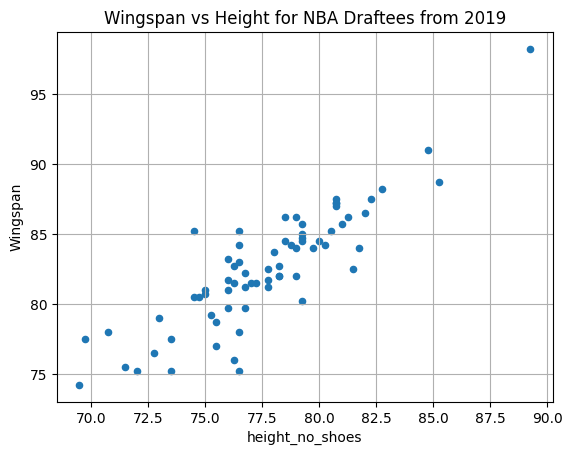

In [7]:

# y축에 윙스팬, x축에 신발을 신지 않았을 때의 키를 둔 산점도를 그리기

draft_data.plot.scatter(x="height_no_shoes", y="wingspan")
plt.title("Wingspan vs Height for NBA Draftees from 2019")
plt.xlabel("height_no_shoes")
plt.ylabel("Wingspan")
plt.grid()


## Step 2. 선형 회귀 다시 짚어보기  
  
  관측된 데이터가 $( x_n, y_n^{(true)})^{N-1}_{n=0}$와 같은 형태로 총 $N$개라고 하자($ x_i $: 인덱스가 $i$인($i+1$번째) 농구선수의 키, $y_i$: 인덱스가 $i$인($i+1$번째)번째 농구선수의 윙스팬). 선형 회귀 모델은 $F(m, b;x) = mx + b$이라고 하자. 이 경우, $x_i$에 대한 예측값 $y_i^{(pred)}$은 $y_i^{(pred)}=F(m, b;x_i ) = m x_i + b$으로 표현해볼 수 있을 것이다. 손실함수를 잔차 제곱의 평균을 의미하는 ‘평균 제곱 오차’로 둘 때, 이 함수 $ℒ_{MSE}$를 $y_n^{(true)}$와 $y_n^{(pred)}$에 대해 표현해보자.
  이제, 앞선 실습에서 작성했던 함수 ordinary_least_squares를 다시 작성해보자. 이후, Step 1에서 불러온 데이터와 이 함수를 활용하여 $m$, $b$의 이상적인 값 $m^*$, $b^*$을 계산해보자. 이 값은 이후 경사하강법을 이용하여 구한 값을 평가하는 지표로 활용할 것이다. 단, 실제 지도학습 상황에서는 이처럼 정확한 값을 구하는 것은 불가능한 경우가 많음을 기억하자.

In [8]:
def ordinary_least_squares(x, y):
    """
    앞선 실습과 동일
    """
    # 여기에 코드 작성
    N = len(x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    m = ((x - mean_x) * (y - mean_y)).sum() / ((x - mean_x) ** 2).sum()
    b = mean_y - m * mean_x
    return m, b

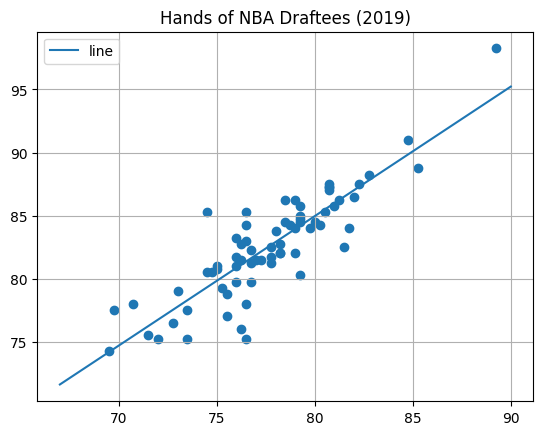

In [9]:
# 윙스팬 vs 신발을 신지 않은 키 데이터의 선형 회귀 모델에서의 m* and b* 값 계산

# 여기에 코드 작성
fig, ax = plt.subplots()
height = draft_data.height_no_shoes
wingspan = draft_data.wingspan
ax.scatter(height, wingspan)
ax.set_title("Hands of NBA Draftees (2019)")
ax.grid()
# 윙스팬, 키 데이터 각각 접근하여 numpy.ndarray로 변환한 후 m*, b* 구하기
# 여기에 코드 작성
height = draft_data.height_no_shoes.values
wingspan = draft_data.wingspan.values
# 이상적인 값인 m*, b* 계산하기
m, b = ordinary_least_squares(height, wingspan)

# ax.plot() 함수 사용하여 그래프 그리기
# x의 정의역 데이터 속 키의 최솟값과 최댓값 사이의 구간으로 잡기
# 구간을 1000개 정도로 나누면 충분함
# 여기에 코드 작성
x = np.linspace(67, 90, 1000)
ax.plot(x, m*x+b, label="line")

# 범례로 들어갈 그래프의 label들을 자동으로 생성해주는 함수
ax.legend()

## Step 3. 여러 $m$, $b$ 값에 대한 $ℒ_{MSE}(m,b)$의 그래프 시각화하기  
  
아래 함수는 $m$, $b$ 값들에 따른 $ℒ_{MSE}(m,b)$의 그래프와, $[m,b]$ 값들이 움직이는 경로(trajectory)에 따른 $ℒ_{MSE}(m,b)$의 변화를 표시해주는 graph_linear_regression_mse이다. 최적의 $m$, $b$ 값에 대한 $ℒ_{MSE}(m,b)$ 값은 검은색 점으로 표시하고, $[m,b]$ 값에 대해 변화하는 각각의 $ℒ_{MSE}(m,b)$값들을 별 모양 점으로 표시함으로써, 우리가 입력해준 $[m, b]$ 값들의 경로가 최적의 값을 잘 찾아가는지 확인하는 데 사용할 수 있다. 함수를 나타내는 코드를 찬찬히 읽어보고, 코드 수정 없이 그대로 실행해보자. 이 함수를 통해 그려지는 이 그래프를 ‘loss landscape’이라고 하는데, 이는 모델 파라미터 값을 각 축으로 하여, 이들 값에 따른 손실함수 값을 나타낸 그래프를 말한다.

In [10]:
def graph_linear_regression_mse(
    x,
    y,
    trajectory=None,
    m_scale=10,
    b_scale=10,
    sample_density=500,
):
    """
    데이터 x, y가 주어졌을 때, 설정한 m(선형 회귀 모델의 기울기), b(선형 회귀 모델의 y절편)값의 범위에서 MSE의 그래프를 그리는 함수.
    m, b의 이상적인 값을 m*, b*이라 할 때, MSE의 그래프는 (m*, b*)을 중심에 두고 그리며, 이 점은 검은색으로 표시됨

    매개변수 (Parameters)
    ----------
    x : np.ndarray, 크기 N의 일차원 배열(shape-(N,))
        사용하는 데이터셋에서 x값들의 배열

    y : np.ndarray, 크기 N의 일차원 배열(shape-(N,))
        사용하는 데이터셋에서 y값들의 배열

    trajectory : 입력 여부 선택 (default=None), 입력하는 경우 np.ndarray, shape-(T, 2) (점 한 개만 나타낼 때) 또는 shape-(N, T, 2) (점 2개 이상을 나타낼 때)
        그래프에 나타내려는 1개, 혹은 T개의 (m, b)점들의 배열. 모델 파라미터 m, b의 값에 따라 변화하는 MSE 값의 ‘궤적’을 나타내는 데 활용 가능함.

    m_scale : int형, 입력 여부 선택 (default=10)
        그래프 그리기에 사용하는 m값의 범위는 [m*-m_scale, m*+m_scale]로 결정

    b_scale : int형, 입력 여부 선택 (default=10)
        그래프 그리기에 사용하는 b값의 범위는 [b*-b_scale, b*+b_scale]로 결정

    sample_density : int형, 입력 여부 선택 (default=500)
        그래프 그리기에 사용되는 축별 샘플 점의 개수, 값이 작을수록 실행 시간이 짧으며, 값이 커질수록 그래프가 정확하게(빠뜨리는 정보 없이) 그려짐.

    반환 값 (Returns)
    -------
    튜플[Figure, Axis]
        그려진 그래프의 Figure과 Axis
    """

    def mse(x, y, m, b):
        """평균 제곱 오차(MSE)를 계산하는 함수"""
        m = np.atleast_1d(m)
        b = np.atleast_1d(b)
        return ((x * m[None] + b[None] - y) ** 2).mean(axis=1)

    # 손실함수 MSE를 최소한으로 만드는 m, b값(m_opt, b_opt) 계산
    # 이전 실습에서는 m*, b* 값을 직접 구해보았음
    # 이번에는 최소 제곱 해를 계산해주는 numpy 모듈의 linalg.lstsq 함수를 사용하여 구현함. 함수에 대해 더 알고 싶다면, 검색해보기!
    # 우리가 평소 구해 오던 m*, b* 값과 결과적으로는 동일한 값을 계산
    A = np.vstack([x, np.ones(len(x))]).T
    m_opt, b_opt = np.linalg.lstsq(A, y, rcond=None)[0]
    l_opt = mse(x, y, m_opt, b_opt)

    center_m = m_opt
    center_b = b_opt

    # MSE 그래프의 figure 생성
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # ax = fig.gca(projection="3d")

    # MSE 그래프의 최소점을 그래프 위에 검은 점으로 표시
    ax.plot(
        [m_opt],
        [b_opt],
        l_opt,
        c="black",
        marker="o",
        zorder=3,
        markersize=7,
    )

    # 그래프를 그리는 데 사용할 m, b값들을 추출하여 numpy 배열의 형태로 생성하고, 이들 값에 대응되는 MSE 값들을 계산
    m_series = np.linspace(center_m - m_scale, center_m + m_scale, sample_density)
    b_series = np.linspace(
        center_b - b_scale, center_b + b_scale, sample_density
    ).reshape(-1, 1) # numpy의 reshape 함수에 –1이 들어가는 것은 어떤 의미일까?

    Z = (b_series + x.reshape(-1, 1, 1) * m_series) - y.reshape(-1, 1, 1)
    Z = np.mean(Z ** 2, axis=0)

    # 그래프 그리기
    m_series, b_series = np.meshgrid(m_series, b_series)
    ax.set_xlabel("Slope: m")
    ax.set_ylabel("Intercept: b")
    ax.set_zlabel("MSE Loss")
    ax.ticklabel_format(style="sci", scilimits=(-1, 2))
    ax.dist = 11
    surf = ax.plot_surface(m_series, b_series, Z, cmap=plt.get_cmap("GnBu"))

    # 지정한 trajectory를 그래프 위에 나타내기
    if trajectory is not None:
        trajectories = np.atleast_2d(trajectory)
        if trajectories.ndim == 2:
            trajectories = trajectories[np.newaxis]
        for trajectory in trajectories:
            m_values, b_values = trajectory.T
            l_values = ((x * m_values[:, None] + b_values[:, None] - y) ** 2).mean(
                axis=1
            )
            ax.plot(
                m_values,
                b_values,
                l_values,
                marker="*",
                zorder=3,
                markersize=7,
            )
    return fig, ax

코드를 살펴보면서 함수의 기능과 구현 방식을 이해했다면, 위의 함수를 활용하여 우리의 데이터에 대한 $ℒ_{MSE}(m,b)$ 그래프를 그려보자. 실행 결과와 코드를 함께 살펴보면 코드를 더 잘 이해할 수 있을 것이다. 이때, trajectory에는 Step 2에서 계산한 $[m^*, b^*]$를 대입하여, 우리가 구한 $[m^*, b^*]$값(출력된 결과 그래프에서 별표 표시)과 graph_linear_regression_mse()에서 계산한 m_opt, b_opt 값이 동일한지, 즉 이 두 점에서 MSE 값이 가장 작게 나타나는지 확인해보자. 검은색 점과 별 모양 점이 겹쳐져서 나타났다면, 우리가 Step 2를 잘 수행한 것이다.

<ipython-input-10-318fea1eedd3>:87: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

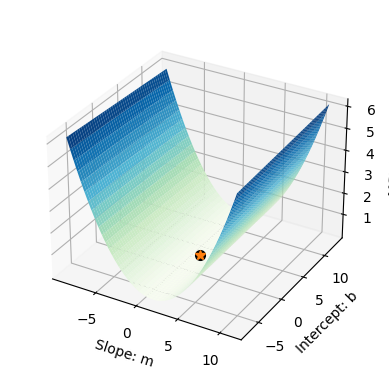

In [11]:
# Step 2에서 계산한 [m*, b*]를 포함하여, 선형 회귀 모델에 대한 MSE 그래프 그리기
graph_linear_regression_mse(height, wingspan, trajectory=[m, b])


  그려진 loss landscape에 겹쳐져 나타난 점은 우리가 찾고자 하는 ‘가장 좋은 모델’의 모델 파라미터값들을 담은 점으로, 이후의 Step 4부터는 이 점을 찾기 위해 그래프를 따라 내려오는 경사하강법을 코드로 구현해볼 것이다. 그 전에, 주어진 데이터에 대한 그래프의 개형이 멕시코 음식인 ‘타코’의 타코쉘 모양을 닮았다는 점에 주목해보자.
  MSE 값인 손실함수의 식 형태를 생각해보면, 앞선 실습(책의 3.4.)에서 다루었었던 $ℒ(w_1, w_2) = 2 w_1^2 + 3 w_2^2$와 유사한 이차식 형태가 나올 것이라고 짐작 가능하다. 그런데 실습의 실행 결과와 앞(교재 3.4.)에서 보았던 그래프의 개형은 많이 다름을 확인해볼 수 있을 것이다. 이러한 차이는 본 실습에서 그려진 그래프에서, 값을 조금 변화시킬 때 나타나는 MSE 값의 변화에 비해, 값을 조금 변화시킬 때 나타나는 MSE 값의 변화가 훨씬 작게 나타나기 때문에 나타난다. 이 변화율의 차이는, 변화율을 이용하여 ‘하강’을 진행하는 경사하강법의 결과에 어떤 영향을 줄까? 이에 대해서는 이 실습의 끝자락에서 다시 논의해보자.

## Step 4. 선형 회귀 모델을 경사하강법으로 학습시키기 위한 기초 함수 만들기  
  
경사하강법으로 모델을 학습시키기 위해 필요한 두 개의 함수를 우선 작성하자. 경사하강법을 구현하는 함수 gradient_step과 손실함수로 사용할 모델이 예측한 값과 실제로 관측된 값 사이의 MSE 값을 계산하는 함수 mean_squared_error를 작성해보자. gradient_step 함수의 경우, 실습 2-1에서 구현해보았던 함수와 동일하다.

In [12]:
def gradient_step(tensors, learning_rate):
  """
  실습 2-1의 동일한 함수 참고
  """
  if isinstance(tensors, torch.Tensor):
      # Only one tensor was provided. Pack
      # it into a list so it can be accessed via
      # iteration
      tensors = [tensors]

  for tensor in tensors:
    if tensor.grad is not None:
      tensor.data -= learning_rate * tensor.grad
      tensor.grad.zero_()

In [13]:
def mean_squared_error(y_pred, y_true):
    """
    모델이 예측한 값과 실제 값 사이의 MSE 값을 계산하는 함수

    매개변수 (Parameters)
    ----------
    y_pred : Tensor, N개의 원소로 구성(shape-(N,))
        N개의 예측값으로 구성된 텐서

    y_true : array_like, N개의 원소로 구성(shape-(N,))
        N개의 실제 값으로 구성딘 배열

    반환 값 (Returns)
    -------
    mse : Tensor, 단일 원소(shape-())
        MES 값을 원소로 갖는인 스칼라 텐서

    실행 예시
    --------
    >>> pred = torch.tensor([1, 2, 3], dtype=torch.float32)
    >>> true = torch.tensor([1, 1, 3], dtype=torch.float32)
    >>> mean_squared_error(pred, true)
    Tensor(0.33333333)
    """
    # 여기에 코드 작성
    mse = torch.mean((y_pred - y_true) ** 2)
    return mse

## Step 5. 선형 모델 클래스 만들기  
  
선형 모델의 모델 파라미터 $m$, $b$를 관리하고 모델을 이용한 에측값을 계산하는 과정을 캡슐화하기 위해, LinearModel이라는 클래스를 생성하자. 이 클래스는 $m$, $b$의 초깃값이 주어지지 않았다면 생성자에서 $m$, $b$ 값을 랜덤하게 초기화하고, forward 메서드를 통해 모델이 내놓는 예측값을 계산하며, $m$, $b$ 값들에 대한 getter 메서드를 데코레이터 @property를 이용하여 구현한다. forward 메서드는 사용자가 정의하는 메서드로, 모델의 순전파(forward pass) 로직을 구현한다. 아래와 같이 데코레이터를 이용하여 구현된 것은, 코드 model.parameters를 통해 텐서들을 튜플 형태로 반환되도록 해 준다. 클래스에 대해 잘 이해가 되지 않는다면, 구글링을 통해 공부하거나
<font color=red>《인공지능 교육단체 OUTTA와 함께 하는! 인공지능 파이썬 기초 다지기》</font>
등의 Python을 다루는 책을 통해 공부하고 넘어가자. 이후, 아래 스켈레톤 코드의 주석을 자세히 살펴보고, 코드를 완성해보자. 이 책의 뒷부분에서도 이처럼 모델을 클래스로 설계하는 비슷한 형태를 많이 보게 될 것이니, 완전히 이해하고 작성하는 것에 신경 써보자.

In [14]:
# 선형 모델 클래스 만들기
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    # 모델의 파라미터 m과 b를 초기화
    self.m = nn.Parameter(torch.empty(1))
    self.b = nn.Parameter(torch.empty(1))

    # 파라미터를 -10에서 10 사이의 균등 분포로 초기화
    nn.init.uniform_(self.m, -10, 10)
    nn.init.uniform_(self.b, -10, 10)


  def forward(self, x):
    """
    x를 입력받아 m * x + b의 계산을 수행, 즉 선형 모델을 이용하여 y의 예측값 계산

    매개변수 (Parameters)
    ----------
    x : N개의 원소로 구성된 배열 혹은 텐서(array_like, shape-(N,))

    반환 값 (Returns)
    -------
    prediction : 선형 모델에 의해 계산된, N개의 예측값을 저장하는 텐서
    """
    return self.m * x + self.b

  @property
  def parameters(self):
    """
    모델 파라미터를 저장하는 두 텐서(기울기, y절편)을 튜플의 형태로 반환
    데코레이터 @property를 붙였기에 메서드가 아닌 속성처럼 사용해야 함.
    즉, model.parameters()가 아닌 model.parameters로 호출

    반환 값 (Returns)
    -------
    Tuple[Tensor, Tensor]
      모델의 학습 가능한 모델 파라미터(기울기, y절편)들을 모아놓은 튜플

    실행 예시
    --------
    >>> model = LinearModel()
    >>> model.parameters
    (Tensor([-7.714269], dtype=float32), Tensor([-6.770146], dtype=float32))
    """
    return (self.m, self.b)



  클래스 생성을 완료했다면, model = LinearModel()을 실행하여 모델을 생성하고, 클래스가 잘 설계되었는지 확인하기 위해 다음 세 가지 사항을 확인해보자. 첫째, model.m과 model.b가 shape-(1,)인 텐서로 잘 정의되는지, 둘째, model.parameters가 이 두 텐서를 정상적으로 반환하는지, 셋째, model(1.)을 호출하면 m*x+b의 값을 갖는 텐서를 정상적으로 반환하는지!

In [15]:
# 클래스가 의도한 대로 잘 설계되었는지 확인하기
model = LinearModel()

# 모델의 파라미터인 기울기 m과 절편 b가 텐서로 잘 정의되는지 확인
assert isinstance(model.m, torch.nn.Parameter) and model.m.size() == (1,)
assert isinstance(model.b, torch.nn.Parameter) and model.b.size() == (1,)

# model.parameter가 두 텐서를 정상적으로 잘 반환하는지 확인
assert model.parameters == (model.m, model.b)

output = model(torch.tensor([1.]))
assert isinstance(output, torch.Tensor) and output.size() == (1,)

### PYTHON 문법 - ASSERT

**ASSERT 설명**

* assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.


```python
>>> a = 3
>>> assert a == 2

#결과
Traceback (most recent call last):
  File "<stdin>", line 1, in <module>
AssertionError
```

**WHY?**
* 왜 assert가 필요한 것일까?

* 어떤 함수는 성능을 높이기 위해 반드시 정수만을 입력받아 처리하도록 만들 수 있다. 이런 함수를 만들기 위해서는 반드시 함수에 정수만 들어오는지 확인할 필요가 있다. 이를 위해 if문을 사용할 수도 있고 '예외 처리'를 사용할 수도 있지만 '가정 설정문'을 사용하는 방법도 있다.

* 아래 코드는 함수 인자가 정수인지 확인하는 코드이다.

lists = [1, 3, 6, 3, 8, 7, 13, 23, 13, 2, 3.14, 2, 3, 7]

```python
def test(t):
    assert type(t) is int, '정수 아닌 값이 있네'

for i in lists:
    test(i)
#결과
AssertionError: 정수 아닌 값이 있네


```

* 요약하자면, lists에 실수가 하나 있으므로 AssertionError가 발생했다. assert 문은 다음 형식으로 작동한다.
> assert 조건, '메시지'

* '메시지'는 생략할 수 있다.

## Step 6. 경사하강법을 통해 모델 학습시키기(1)  
  이제, 본격적으로 적합한 선형 회귀 모델을 찾기 위해 경사하강법을 시행해보자. 우리는 경사하강법의 스텝을 반복해나가면서 $m$과 $b$값, 손실함수($ℒ_{MSE}$) 값이 어떻게 변화하는지 확인할 것이다. 또한, Step 3의 graph_linear_regression_mse 함수를 활용하여 손실함수 값이 어떻게 변화했는지 시각화해볼 것이며, 경사하강법을 통해 구한 우리의 선형 회귀 모델을 데이터의 산점도와 함께 나타내어 적절한 학습이 이루어졌는지 확인해볼 것이다.
  우선, 아래 코드를 작성하여 경사하강법 시행을 위한 준비를 마치자.


In [16]:
heights_torch = torch.tensor(draft_data.height_no_shoes.values, dtype=torch.float32)  # 관측된 x값[단위: inch]
wingspan_torch = torch.tensor(draft_data.wingspan.values, dtype=torch.float32)  # 관측된 y값[단위: inch]


# Step 5에서 작성한 모델 클래스의 인스턴스를 생성(별도로 인자를 전달하지 않음)
# 생성한 인자를 ‘model’이라는 변수에 할당(assign)
model = LinearModel()

# 경사하강법을 통해 순차적으로 구해질 모델 파라미터를 저장할 배열, `trajectory`를 초기화
# [(m0, b0), (m1, b1), ... ] 와 같은 형태
trajectory = []

# 관측된 데이터 ‘전체’를 이용하여 계산되는 손실함수 값을 바탕으로 모델 파라미터를 갱신하는 횟수, 즉 경사하강법에서 시행하는 스텝 수
# ‘epoch’이라는 용어는 다음 절에서 자세히 설명할 예정
num_epochs = 10

# 경사하강법의 하이퍼파라미터인 학습률 값 설정
# 본 실습에서는 데이터셋을 바탕으로 얻을 수 있는 합리적인 추측값인 1E-4를 사용
# 학습률을 결정하는 방법은 많으며 꼭 이 값을 사용해야만 하는 이유는 없음
learning_rate = 1e-4

 이제 학습을 진행시키며, $m$과 $b$값, 손실함수($ℒ_{MSE}$) 값을 3개의 그래프로 동시에 나타낼 것이다. matplotlib 라이브러리를 사용하여 보일 것이다.

이제, 경사하강법으로 선형 회귀 모델을 학습시키는 코드를 완성해보자. 주석을 참고하여 코드를 작성하고 성공적으로 실행시키면, 위 코드에서 그려졌던 3 개의 좌표평면에 그래프가 채워질 것이다.

In [17]:
# 손실값, 기울기(m)와 절편(b) 값을 저장할 리스트 초기화
loss_values = []
m_values = []
b_values = []


for epoch in range(num_epochs):
    # 전체 데이터셋에 대해 ‘순전파(용어는 다음 절에서 설명)’를 진행
    # 주어진 모든 키 데이터에 대한 윙스팬 예측값을 변수 y_pred에 저장
    # 여기에 코드 작성
    y_pred = model(heights_torch)

    # Step 4에서 작성한 mean_squared_error를 활용하여, 실제 윙스팬 값과 예측한 윙스팬 값 사이의 MSE로 정의되는
    # 손실함수 값을 계산하여 변수 loss에 할당. 즉, MSE 함수가 손실함수가 된다.
    # 여기에 코드 작성
    loss = mean_squared_error(y_pred, wingspan_torch)

    # 실습 2-1에서 다루었던 torch 라이브러리의 자동미분 기능을 활용하여, 우리의 모델 파라미터 값에서의 손실함수의 편도함수 계산
    # 계산된 손실함수를 활용하여 역전파를 진행
    # 여기에 코드 작성
    loss.backward()

    # append 함수를 사용하여, 현재의 모델 파라미터 값 (m, b)을 trajectory 배열에 추가
    # 여기에 코드 작성
    trajectory.append((model.m.item(), model.b.item()))

    # Step 4에서 작성한 gradient_step 함수를 활용하여, 경사하강법의 한 스텝을 진행하여 모델 파라미터를 갱신
    # 여기에 코드 작성
    gradient_step(model.parameters, learning_rate)

    # 손실값, 기울기(m)와 절편(b) 값을 리스트에 저장
    loss_values.append(loss.detach().clone().numpy())
    m_values.append(model.m.detach().clone().numpy())
    b_values.append(model.b.detach().clone().numpy())
    print(f"Epoch {epoch+1}----------------------------")
    print(f"loss: {loss:.6f}")

Epoch 1----------------------------
loss: 215234.312500
Epoch 2----------------------------
loss: 9396.215820
Epoch 3----------------------------
loss: 414.119629
Epoch 4----------------------------
loss: 22.170271
Epoch 5----------------------------
loss: 5.066894
Epoch 6----------------------------
loss: 4.320569
Epoch 7----------------------------
loss: 4.288002
Epoch 8----------------------------
loss: 4.286581
Epoch 9----------------------------
loss: 4.286520
Epoch 10----------------------------
loss: 4.286517


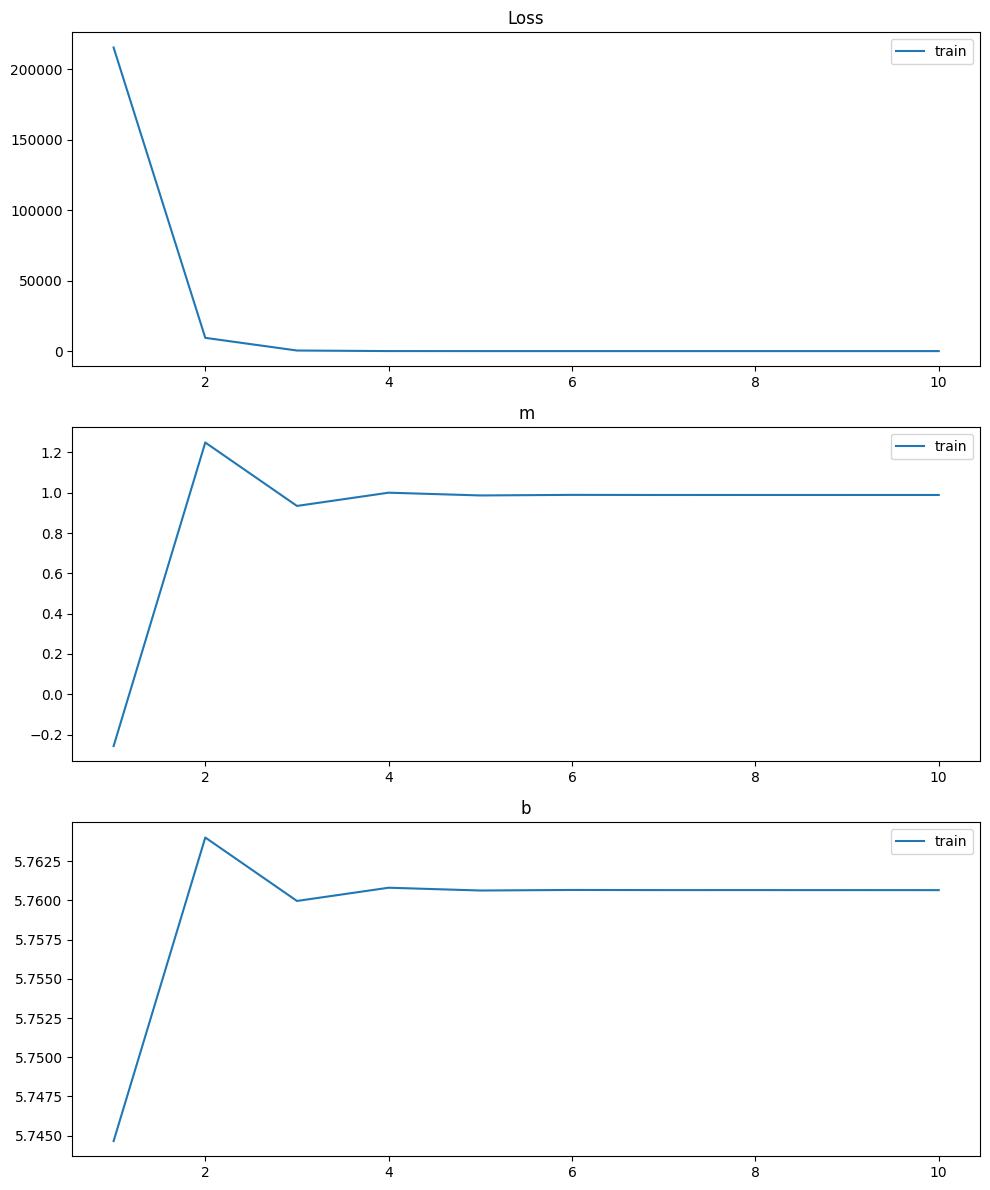

In [18]:
# 학습 결과 시각화
# 3x1 그래프 그리기
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# loss 그래프
axs[0].plot(range(1, num_epochs + 1), loss_values, label='train')
axs[0].set_title('Loss')
axs[0].legend()

# m 그래프
axs[1].plot(range(1, num_epochs + 1), m_values, label='train')
axs[1].set_title('m')
axs[1].legend()

# b 그래프
axs[2].plot(range(1, num_epochs + 1), b_values, label='train')
axs[2].set_title('b')
axs[2].legend()

plt.tight_layout()
plt.show()

 그려진 3개의 그래프를 살펴보자. 스텝을 거듭할수록 손실함수 값이 0에 가까워지고, 두 모델 파라미터 값이 하나의 값에 수렴하는 형태가 보인다면 우리는 학습이 잘 이루어졌다고 판단할 수 있을 것이다.

 이번에는 아래의 코드를 실행시켜보자. 첫 번째 시각화 코드인 graph_linear_regression_mse를 통해 loss landscape 상에서 손실함수 값이 어떻게 변화해갔는지 확인해보고, 두 번째 코드를 통해 데이터의 산점도와 이상적인 선형 회귀 모델, 그리고 우리가 구한 선형 회귀 모델을 함께 나타내어보자.

<ipython-input-10-318fea1eedd3>:87: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

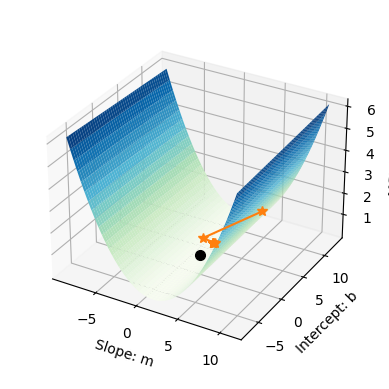

In [19]:
# Step 3에서 작성했던 graph_linear_regression_mse 함수를 활용한 loss landscape 시각화
graph_linear_regression_mse(height, wingspan, trajectory = trajectory)

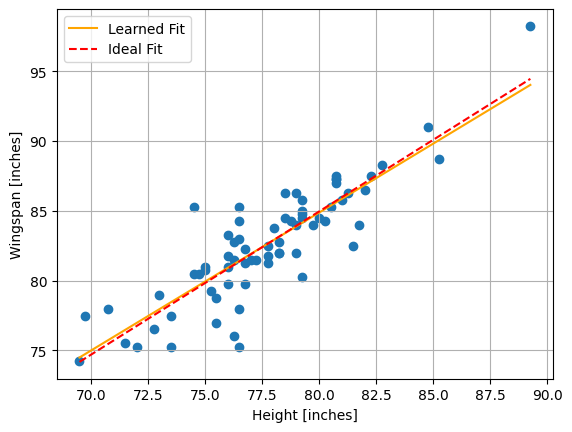

In [20]:
# 데이터의 산점도, 이상적인 선형 회귀 모델, 직접 구한 선형 회귀 모델 시각화
fig, ax = plt.subplots()

ax.scatter(height, wingspan)
m, b =  ordinary_least_squares(height, wingspan)
x = np.linspace(height.min(), height.max(), 1000)

ax.plot(x, model.m.item() * x + model.b.item(), c="orange", label="Learned Fit")
ax.plot(x, m * x + b, c="red", ls= "--", label="Ideal Fit")
ax.legend()
ax.grid(True)
ax.set_xlabel("Height [inches]")
ax.set_ylabel("Wingspan [inches]");

이번에도 다양한 모델 파라미터 값에 따른 결과를 확인하기 위해, 전체 과정을 여러 번 실행해보자. 산점도 그래프의 x축 범위를 height.min()부터 height.max()로 바꾸어서도 그래프를 다시 그려 보자. 무언가 확실히 잘못되었다는 느낌이 들 것이다.  
전반적으로, loss landscape 그래프를 그린 결과에서는 원래 스텝을 거듭할수록 검은색 점에 가까워지는 경로가 나타나야 하는데, $m$ 값은 잘 변화한 듯 하지만 $b$ 값은 초기의 값으로부터 크게 변화하지 못하면서 결국 검은색 점에 도달하지 못하는 경우가 발생할 수 있다. 산점도에서는 우리가 구한 모델이 이상적인 모델과는 다르며, 특히 y-절편 값이 이상적인 모델과 확연히 다름을 확인할 수 있을 것이다.

한 가지만 더 확인해보자. 학습을 통해 구해진 모델이 초깃값에 얼마나 의존적인지 확인해볼 것이다. 동시에 여러 개의 모델을 생성하면 $m$, $b$의 초깃값들이 각각 다르게 설정될 것인데, 이 초깃값에 따라 얼마나 결과가 다르게 나타나는지를 loss landscape와 산점도로 시각화하는 아래 코드를 실행시켜보자.

<ipython-input-10-318fea1eedd3>:87: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


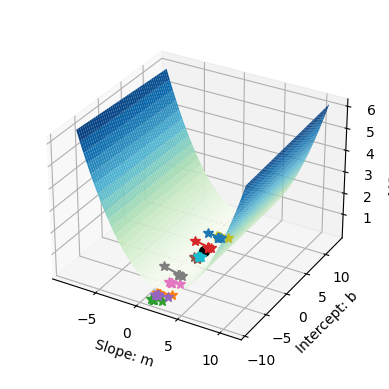

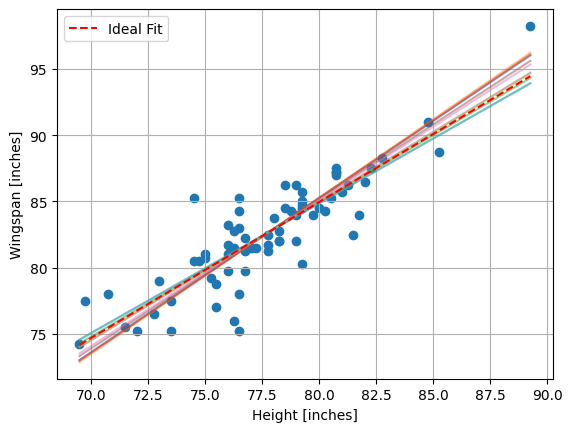

In [21]:

num_models = 10
trajectories = [[] for i in range(num_models)]
models = [LinearModel() for i in range(num_models)]

num_epochs = 10
step_size = 1e-4

for n in range(num_epochs):
    for model_id, model in enumerate(models):
        y_pred = model(heights_torch)
        loss = mean_squared_error(y_pred, wingspan_torch)
        loss.backward()
        gradient_step(model.parameters, step_size)
        trajectories[model_id].append((model.m.item(), model.b.item()))

trajectories = np.array(trajectories)
graph_linear_regression_mse(height, wingspan, trajectory=trajectories)

fig, ax = plt.subplots()
ax.scatter(height, wingspan)
m, b = ordinary_least_squares(height, wingspan)
x = np.linspace(height.min(), height.max(), 1000)
for n, model in enumerate(models):
    ax.plot(x, model.m.item() * x + model.b.item(), alpha=0.5)
ax.plot(x, m * x + b, c="red", ls="--", label="Ideal Fit")
ax.legend()
ax.grid(True)
ax.set_xlabel("Height [inches]")
ax.set_ylabel("Wingspan [inches]");

실행 결과를 보면, 초깃값에 따라 학습된 모델의 결과가 크게 달라짐을 확인해볼 수 있을 것이다. 여러 차례 살펴보았듯, 현재 우리가 구현한 경사하강법을 통해서는 이상적인 모델과 가까운 모델을 얻기가 쉽지 않다. 그 이유가 무엇일지 생각해보자. 이유와 해결책은 바로 다음 과정인, Step 7에서 다룬다.

## Step 7. 데이터 전처리: 데이터를 표준화하기

Step 6의 마지막 과정에서 그린 loss landscape를 찬찬히 살펴보면, Step 6에서 우리가 바라던 학습이 이루어지지 않았던 이유는 loss landscape가 $b$보다 $m$에 대해 더 민감하게 변화하기 때문이다. 이는 사용한 데이터의 중심이 원점($x$(키)=0, $y$(윙스팬)=0)으로부터 멀리 떨어져 있기 때문이다. 데이터셋의 산점도에 선형 회귀 모델을 함께 그린 그래프(책의 그림을 확인하자!)와 연관지어서 이 점을 생각해보자.

y-절편이 동일하고, 기울기가 다른 두 일차함수의 함숫값의 차이는 원점 근방의 점에서보다 원점으로부터 멀리 떨어진 점에서 더 크게 나타날 것이다. 반면, 기울기가 동일하고, y-절편이 다른 두 일차함수의 함숫값 차이는 원점으로부터의 거리와 상관없이 일정하게 나타날 것이다. 우리가 사용한 데이터의 중심(평균값)은 실제로 키 80인치, 윙스팬 85인치로, 원점과는 상당한 거리가 있다. 따라서, 선형 회귀 모델의 기울기인 $m$값에 약간의 차이만 생겨도 예측값에 큰 차이가 생기며 손실함수 값 또한 차이가 크게 생기는 것이다. $b$ 값의 차이는 이에 비해 예측값에 주는 영향이 적기에, 손실함수에 주는 영향이 보다 작았던 것이다. 이는 loss landscape의 형태가 ‘타코쉘’과 닮은 이유이기도 하다.  
  
  경사하강법은 loss landscape의 각 축방향 기울기 값에 비례하여 모델 파라미터를 갱신하는 방법이고, 우리는 다음과 같은 식을 사용하였다.  
  
$\mathbf{w_{new}} = \mathbf{w_{old}} - \delta \nabla ℒ(w_1, ..., w_M) |_{\mathbf{w} = \mathbf{w_{old}}}$  
  
$m$, $b$의 값을 갱신할 때, 각각에는 학습률 $\delta$에 $\frac{\partial ℒ}{\partial m}$이나 $\frac{\partial ℒ}{\partial b}$를 곱한 값을 뺀다는 의미를 담고 있는 식이다. 이때, 우리의 손실함수에서는  값의 크기가 보다 컸기에 값의 변화가 더 크게 나타나게 된 것이다. 이를 개선하기 위해, 우리는 경사하강법에 사용할 데이터의 중심을 원점으로 이동시켜보는 방안을 생각해볼 수 있다. 데이터의 평균을 0, 표준편차를 1로 맞추는 ‘표준화’를 진행하고, 이후에 경사하강법을 실행해보자. 이처럼 학습을 진행하기 전 데이터를 수정하는 것을 데이터 전처리라고 하며, 표준화 외의 대표적인 전처리 방법은 4절의 ‘더 알아보기 2’에서 추가적으로 다루어볼 예정이다.  
  
 이제 표준화를 직접 구현해보자. 표준화는 각 데이터에서 전체 데이터의 평균을 빼고, 그를 표준편차로 나누어 진행한다. 아래의 세 코드는 각각 데이터를 표준화하는 함수, 이 함수를 이용하여 우리의 데이터셋인 키와 윙스팬을 각각 표준화하는 코드, 그리고 표준화된 키와 윙스팬 데이터의 산점도를 그리는 코드이다. 이를 차례로 시행시켜보고, 표준화가 잘 이루어졌는지 확인해보자.

In [22]:
def norm(x):
    """
    표준화한 데이터를 반환하는 함수

    매개변수 (Parameters)
    ----------
    x : array_like, shape-(N,)

    반환 값 (Returns)
    -------
    normed_x : array_like, shape-(N,)
    """
    return (x-x.mean())/x.std()

In [23]:
normed_height = norm(height) # 키 데이터를 표준화
normed_wingspan = norm(wingspan) # 윙스팬 데이터를 표준화

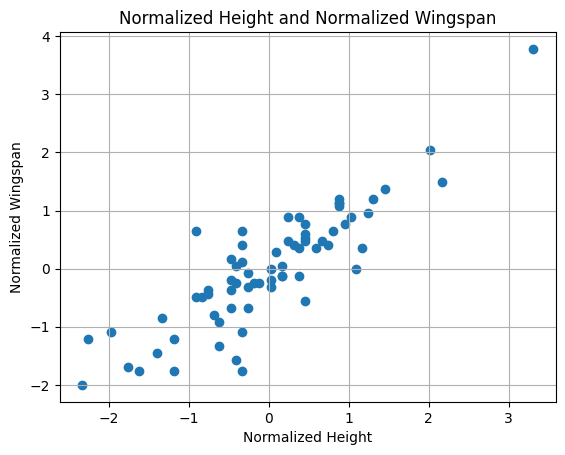

In [24]:
# 표준화된 데이터 시각화
fig, ax = plt.subplots()
ax.scatter(normed_height, normed_wingspan)
ax.grid()
plt.xlabel('Normalized Height') # x축 레이블 설정
plt.ylabel('Normalized Wingspan')  # y축 레이블 설정
plt.title('Normalized Height and Normalized Wingspan')  # 그래프 제목 설정
plt.show()  # 그래프 표시

## Step 8. 경사하강법을 통해 모델 학습시키기(2)  
  
  이제, Step 6과 동일한 과정을 통해 표준화한 데이터에 대해 경사하강법을 진행해보자. Step 6에서 설정했었던 num_epoch값과 learning_rate 값은 그대로 해보아도 좋지만, 확실한 변화를 보기 위해 num_epoch = 100, learning_rate = 0.1의 큰 값을 넣어 해보는 것을 추천한다.
  
  경사하강법을 진행해나가면서, $m$값, $b$값, 손실함수($ℒ_{MSE}$) 값을 3개의 그래프로 시각화해보자. 다음으로는 loss landscape를 이용한 모델 파라미터 및 손실함수 값 변화도 시각화해보고, 산점도에 새로운 모델과 이상적인 모델을 함께 표시해보기도 하자. 조금 귀찮더라도, 이후의 실습들을 해결하는 데에도 도움이 될 것이니 한 번씩 더 해보길 바란다. Step 6에서와 비슷한 과정인 만큼 책에는 별도로 스켈레톤 코드를 넣지 않았고, 이번에는 스스로 코드를 작성해보는 것에 도전해보아도 좋을 것이다.

[주의사항]

epochs 수와 learning rate를 조정해 가며 올바르게 학습시켜 보시길 바랍니다.
**이때 epochs 수는 30을 초과할 수 없으며, 초과한 경우 0점 처리됩니다.**


In [25]:
# 데이터를 Tensor로 변환
normed_heights_torch = torch.tensor(normed_height, dtype=torch.float32)
normed_wingspans_torch = torch.tensor(normed_wingspan, dtype=torch.float32)

# trajectory 리스트 초기화
trajectory = []

# class instance 선언
model=LinearModel()


# epochs, learning rate 적절히 설정
# epochs 최대 50회 설정 가능, 50회 넘어갈 시 Step 8 점수 0점
# learning rate 값을 변화시켜 가며, dist_from_taret 함수의 값을 감소시킬 것
num_epochs_normed = 50
learning_rate = 0.1


# 손실값, 기울기(m)와 절편(b) 값을 저장할 리스트 초기화
loss_values = []
m_values = []
b_values = []


for epoch in range(num_epochs_normed):
    # 전체 데이터셋에 대해 ‘순전파(용어는 다음 절에서 설명)’를 진행
    # 주어진 모든 키 데이터에 대한 윙스팬 예측값을 변수 y_pred에 저장
    # 여기에 코드 작성
    y_pred = model(normed_heights_torch)

    # Step 4에서 작성한 mean_squared_error를 활용하여, 실제 윙스팬 값과 예측한 윙스팬 값 사이의 MSE로 정의되는
    # 손실함수 값을 계산하여 변수 loss에 할당
    # 여기에 코드 작성
    loss = mean_squared_error(y_pred, normed_wingspans_torch)

    # 실습 2-1에서 다루었던 torch 라이브러리의 자동미분 기능을 활용하여, 우리의 모델 파라미터 값에서의 손실함수의 편도함수 계산
    # 계산된 손실함수를 활용하여 역전파를 진행
    # 여기에 코드 작성
    loss.backward()

    # append 함수를 사용하여, 현재의 모델 파라미터 값 (m, b)을 trajectory 배열에 추가
    # 여기에 코드 작성
    trajectory.append((model.m.item(), model.b.item()))

    # Step 4에서 작성한 gradient_step 함수를 활용하여, 경사하강법의 한 스텝을 진행하여 모델 파라미터를 갱신
    # 여기에 코드 작성
    gradient_step(model.parameters, learning_rate)

    # 손실값, 기울기(m)와 절편(b) 값을 리스트에 저장
    loss_values.append(loss.detach().clone().numpy())
    m_values.append(model.m.detach().clone().numpy())
    b_values.append(model.b.detach().clone().numpy())
    print(f"Epoch {epoch+1}----------------------------")
    print(f"loss: {loss:.6f} [{len(x):>5d}]")



Epoch 1----------------------------
loss: 13.737791 [ 1000]
Epoch 2----------------------------
loss: 8.881400 [ 1000]
Epoch 3----------------------------
loss: 5.773312 [ 1000]
Epoch 4----------------------------
loss: 3.784134 [ 1000]
Epoch 5----------------------------
loss: 2.511060 [ 1000]
Epoch 6----------------------------
loss: 1.696293 [ 1000]
Epoch 7----------------------------
loss: 1.174842 [ 1000]
Epoch 8----------------------------
loss: 0.841114 [ 1000]
Epoch 9----------------------------
loss: 0.627528 [ 1000]
Epoch 10----------------------------
loss: 0.490832 [ 1000]
Epoch 11----------------------------
loss: 0.403347 [ 1000]
Epoch 12----------------------------
loss: 0.347357 [ 1000]
Epoch 13----------------------------
loss: 0.311523 [ 1000]
Epoch 14----------------------------
loss: 0.288590 [ 1000]
Epoch 15----------------------------
loss: 0.273912 [ 1000]
Epoch 16----------------------------
loss: 0.264518 [ 1000]
Epoch 17----------------------------
loss: 0.258

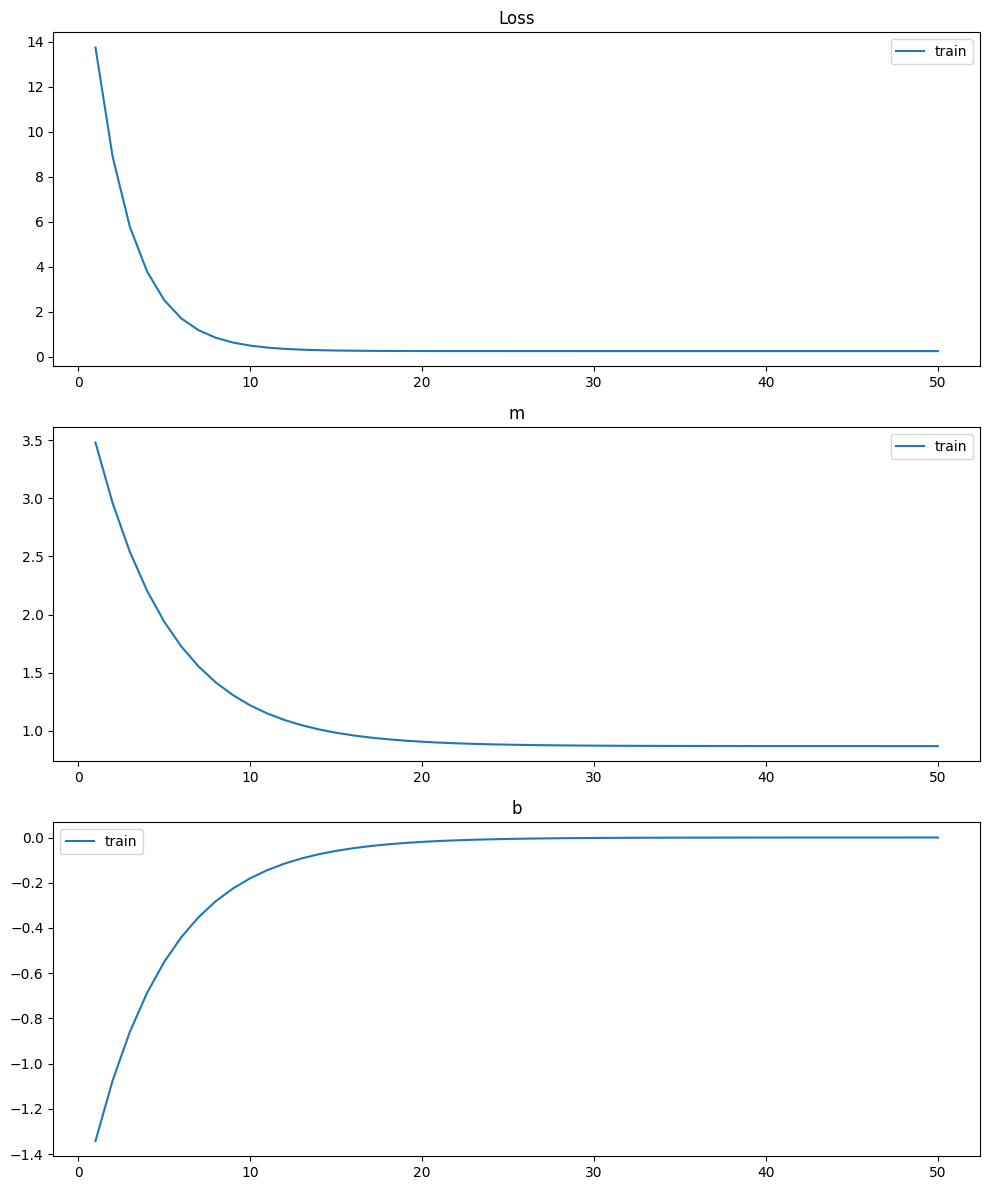

In [26]:
# 학습 결과 시각화
# 3x1 그래프 그리기
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# loss 그래프
axs[0].plot(range(1, num_epochs_normed + 1), loss_values, label='train')
axs[0].set_title('Loss')
axs[0].legend()

# m 그래프
axs[1].plot(range(1, num_epochs_normed + 1), m_values, label='train')
axs[1].set_title('m')
axs[1].legend()

# b 그래프
axs[2].plot(range(1, num_epochs_normed + 1), b_values, label='train')
axs[2].set_title('b')
axs[2].legend()

plt.tight_layout()
plt.show()

<ipython-input-10-318fea1eedd3>:87: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

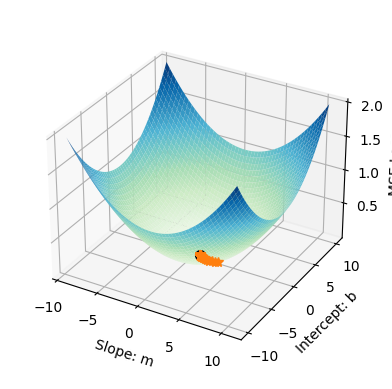

In [27]:
# Step 3에서 작성했던 graph_linear_regression_mse 함수를 활용한 loss landscape 시각화
graph_linear_regression_mse(normed_height, normed_wingspan, trajectory = trajectory)

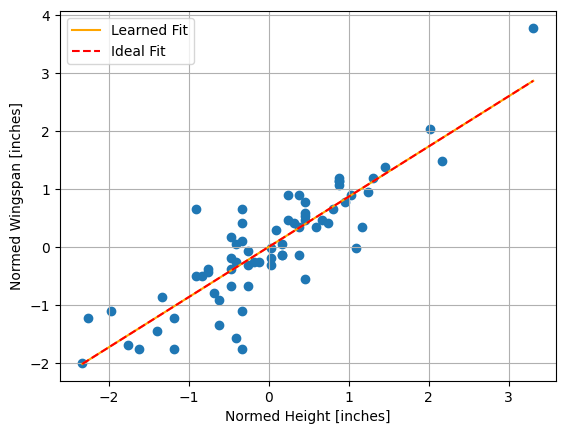

In [28]:
# 데이터의 산점도, 이상적인 선형 회귀 모델, 직접 구한 선형 회귀 모델 시각화
fig, ax = plt.subplots()

ax.scatter(normed_height, normed_wingspan)
m, b =  ordinary_least_squares(normed_height, normed_wingspan)
x = np.linspace(normed_height.min(), normed_height.max(), 1000)

ax.plot(x, model.m.item() * x + model.b.item(), c="orange", label="Learned Fit")
ax.plot(x, m * x + b, c="red", ls= "--", label="Ideal Fit")
ax.legend()
ax.grid(True)
ax.set_xlabel("Normed Height [inches]")
ax.set_ylabel("Normed Wingspan [inches]");

코드를 잘 작성했다면, 다양한 $m$, $b$의 초깃값에 대한 loss landscape 시각화 결과를 나타내었을 때, loss landscape의 개형이 ‘타코쉘’이 아닌, 3.4.에서 다루었던 이차식의 형태에 가까워진 점을 확인해볼 수 있을 것이다. 즉, 우리가 거친 표준화 작업이, 예상대로 손실함수의 , 데이터 크기에 대한 의존도 차이를 줄여준 것이다. 그 결과, 경사하강법이 진행됨에 따라 우리가 바라던 대로 손실함수 값이 순조롭게 0에 가까워짐을 시각적으로 확인할 수 있으며, 이는 초기의 파라미터 값에도 크게 의존하지 않음 또한 확인 가능하다.

## Step 9. 표준화한 데이터를 통해 얻은 모델을 원래 데이터에 맞게 조정하기  
  
Step 8을 진행하며 순조로움을 느꼈겠지만, 아직 우리에게는 한 가지 문제가 남아있다. 새롭게 구한 선형 모델은 표준화된 키와 표준화된 윙스팬의 관계를 설명하는 모델로, 표준화된 키 데이터를 입력하면 표준화된 윙스팬의 예상값을 반환해주는 모델이다. 다만, 우리가 궁극적으로 원했던 것은 표준화하지 않은 키 데이터로 표준화하지 않은 예상 윙스팬 데이터를 얻는 작업이므로, 이를 수행하기 위해서는 약간의 보정 작업을 거쳐야 한다.  
  
  우리가 얻은 모델은, $\bar{x}$, $\bar{y}$를 각각 관측된 키와 윙스팬 평균, $Std[x]$, $Std[y]$를 관측된 키와 윙스팬 표준편차라고 할 때, $\hat{x} = \frac{x-\bar{x}}{Std[x]}$,$\hat{y} = \frac{y-\bar{y}}{Std[y]}$ 의 관계를 $\hat{y}=m\hat{x}+b$로 설명하는 모델이다. 아래의 함수 processed_predictions는 우리의 표준화된 데이터에 대한 모델과 사용한 데이터의 평균, 표준편차를 알고 있을 때, 새로운 키를 입력하면 예상되는 윙스팬 값을 바로 반환해주는 함수이다. 위의 $\hat{x}$, $\hat{y}$에 대한 수식과 모델의 수식을 잘 정리해서, 어떤 연산을 통해 함수를 완성할 수 있을지 생각하고 코드를 완성해보자.

In [29]:
def processed_predictions(
    model,
    new_x,
    height_mean=height.mean(),
    height_std=height.std(),
    wingspan_mean=wingspan.mean(),
    wingspan_std=wingspan.std(),
):
    """
    한 개, 혹은 더 많은 개수의 키(단위: inch)가 주어질 때, 입력받은 표준화된 데이터에 대한 모델을 이용하여 예상되는 윙스팬(단위: inch)를 반환하는 함수

    매개변수 (Parameters)
    ----------
    model : Callable[[array_like], Tensor]
        표준화된 데이터에 대해 학습된 모델

    new_x : array_like, shape-(N,)
        N개의 새로운 키 데이터(단위: inch)

    height_mean : float
        학습에 사용된 데이터셋의 키 평균값(단위: inch)

    height_std : float
        학습에 사용된 데이터셋의 키 표준편차(단위: inch)

    wingspan_mean : float
        학습에 사용된 데이터셋의 윙스팬 평균값(단위: inch)

    wingspan_std : float
        학습에 사용된 데이터셋의 윙스팬 표준편차(단위: inch)

    반환 값 (Returns)
    -------
    numpy.ndarray, shape-(N,)
        N개의 윙스팬 예상값(단위: inch)

    주의사항
    -----
    모델의 결과물을 tensor 형태가 아닌 numpy array 형태로 받아 사용해야 함
    방법이 기억나지 않는다면, 실습 3을 참고.
    """
    # x를 이용하여 x hat를 구하고, 모델을 통해 y hat를 구한 후, 다시 y hat를 y로 바꾸기

    if isinstance(new_x, torch.Tensor):
        new_x = new_x.detach().numpy()

    x_hat = (new_x - height_mean) / height_std  # 표준화된 키 계산
    x_hat_tensor = torch.tensor(x_hat, dtype=torch.float32)  # 텐서로 변환
    y_hat = model(x_hat_tensor).detach().numpy()  # 표준화된 키에 대한 예상 윙스팬 계산
    y = y_hat * wingspan_std + wingspan_mean  # 표준화 되돌리기

    return y


이제 경사하강법을 통한 선형 회귀 모델 학습 과정 구현이 끝났다. 마지막으로, 표준화를 통해 얻은 모델과 위의 함수를 활용하여 얻는 최종적인 모델을 산점도와 함께 시각화해보자. 그래프를 그리기 위해, numpy의 linspace 함수를 활용하여, x값(키)들을 촘촘하게 선정하고, 이에 따른 y값(윙스팬)들을 계산하여 함께 나타내어주면 된다.

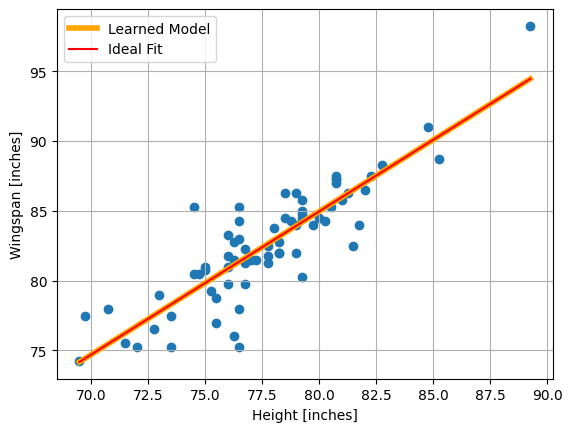

In [30]:
# 모델의 예측 결과를 원래 데이터와 함께 시각화
fig, ax = plt.subplots()
ax.scatter(height, wingspan) # 원래 데이터의 산점도

x = np.linspace(height.min(), height.max(), 1000) # x 값 범위 설정
# 모델을 통해 최종적으로 얻는 y 계산
# 여기에 코드 작성


# 모델을 통해 최종적으로 얻는 y 계산
y = processed_predictions(
    model,
    x,
    height_mean=height.mean(),
    height_std=height.std(),
    wingspan_mean=wingspan.mean(),
    wingspan_std=wingspan.std(),
)


ax.plot(x, y, color="orange", lw=4, label="Learned Model") # 학습된 모델의 예측 결과를 그래프에 표시


m, b = np.polyfit(height, wingspan, 1)  # 이상적인 선형 회귀 모델 계산
ax.plot(x, m * x + b, c="red", label="Ideal Fit")  # 이상적인 선형 회귀 모델을 그래프에 표시


ax.grid(True)  # 그리드 표시
ax.legend()  # 범례 표시
ax.set_xlabel("Height [inches]")  # x축 레이블 설정
ax.set_ylabel("Wingspan [inches]")  # y축 레이블 설정
plt.show()  # 그래프 표시

위 코드를 잘 완성하면, 이상적인 선형 회귀 모델과 비슷한 모델을 직접 얻어내었음을 확인해볼 수 있을 것이다!

## 배운 내용 되돌아보기  
  
이번 실습에서는 실습 3에서 배운 자동미분 라이브러리를 활용하여, 경사하강법을 통해 선형 회귀 모델을 학습시켜보았다. 실습에서 배운 내용들을 가볍게 정리해보자.

- 선형 회귀 모델을 세우고, 모델을 평가하기 위한 손실함수를 MSE로 작성해보았다. 물론, 선형 회귀 모델이 아닌 모델에 대해서도 이 실습을 변형하여 적용할 수 있다.
- 손실함수가 실제로 최솟값을 갖는 모델 파라미터의 이상적인 값을 미리 계산해두었다.
- 모델 파라미터에 따른 손실함수의 값을 그래프로 나타내는 loss landscape를 시각화했다.
- 모델을 python 클래스 형태로 코딩하여, 모델 파라미터를 초기화 및 수정하고 모델의 예측값을 반환(return)하는 ‘순전파’를 진행할 수 있도록 했다. (순전파가 무엇인지는 다음 절에서 배운다.)
- 라이브러리의 자동미분 기능을 활용하여 경사하강법을 코딩으로 구현하였고, 이를 활용하여 모델을 학습시켜보았다. 이 과정에서 ‘역전파’를 진행하였다. (역전파가 무엇인지도 다음 절에서 배운다.) 이때, 학습률 등의 하이퍼파라미터는 이 모델에 적합할 값으로 대략적인 값을 예상하여 사용하였다.
- 모델을 학습시키며, 실시간으로 모델 파라미터 값과 손실함수 값, 그리고 구한 모델 파라미터 값과 이상적인 모델 파라미터 값의 차이가 어떻게 변화하는지 실시간으로 확인해보았다. 또한, loss landscape에 손실함수 값 변화를 궤적으로 나타내어보았다.
- 모델의 학습 결과가 만족스러운지 여러 방법을 사용하여 판단해보았고, 그 원인을 선형 모델의 기울기값과 y-절편 값의 의미와 관련지어 생각해보았다. 이를 개선하기 위한 방법으로 데이터의 표준화를 도입하였다.
- 데이터를 표준화시킨 이후 같은 방법으로 경사하강법을 진행하였고, 표준화하지 않은 경우와 대조해보았다.
- 표준화한 데이터로 학습을 시켰지만, 최종적인 결과로는 표준화되지 않은 데이터를 얻기 위해 데이터를 다시 처리해주었다. 그 결과, 이상적인 선형 회귀 모델과 매우 유사한 모델을 얻을 수 있었다.